## Notebook: Image Recognition - Gender Detection

* Este conjunto de datos en Kaggle no permite trabajar con el método "flow_from_directory" de keras, ya que las imágenes deben estar en diferentes carpetas según el objetivo y el tipo de datos (entrenamiento, validación, prueba). Para esto estoy trabajando con el método "flow".
* Limitación de memoria, por lo que estoy usando una cantidad reducida de imágenes para entrenar y validar.

### Now let´s start

En este proyecto, construiremos un algoritmo de aprendizaje automático usando CNN para predecir a partir de una imagen si la celebridad es hombre o mujer.

---

## Dataset

Para este proyecto, utilizaremos el conjunto de datos de CelebA (http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), que está disponible en Kaggle.

Descripción del conjunto de datos CelebA de kaggle (https://www.kaggle.com/jessicali9530/celeba-dataset):
### Context
Estos datos fueron recopilados originalmente por investigadores de MMLAB, la Universidad China de Hong Kong (referencia específica en la sección de Agradecimientos).

### Content

#### Overall

202,599 número de imágenes de rostros de varias celebridades
10,177 identidades únicas, pero no se dan los nombres de las identidades
40 anotaciones de atributos binarios por imagen
5 lugares emblemáticos

#### Data Files

-img_align_celeba.zip: Todas las imágenes de rostros, recortadas y alineadas

-list_eval_partition.csv: partición recomendada de imágenes en conjuntos de entrenamiento, validación y prueba. Las imágenes 1-162770 son de entrenamiento, 162771-182637 son de validación, 182638-202599 son de prueba

-list_bbox_celeba.csv: información del cuadro delimitador para cada imagen. "x_1" e "y_1" representan la coordenada del punto superior izquierdo del cuadro delimitador. "ancho" y "alto" representan el ancho y el alto del cuadro delimitador

-list_landmarks_align_celeba.csv: Imagen de puntos de referencia y sus respectivas coordenadas. Hay 5 puntos de referencia: ojo izquierdo, ojo derecho, nariz, boca izquierda, boca derecha

-list_attr_celeba.csv: Etiquetas de atributos para cada imagen. Hay 40 atributos. "1" representa positivo mientras que "-1" representa negativo

---


### Import libraries

In [6]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils,array_to_img,img_to_array,load_img
from keras.optimizers import SGD

from IPython.core import display
from IPython.core.display import HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

In [7]:
import tensorflow as tf
print(tf.__version__)

2.12.0


## Step 1: Data Exploration

Usaremos el CelebA Dataset, que incluye imágenes de 178 x 218 px. A continuación se muestra un ejemplo de cómo se ven las imágenes.

In [8]:
# set variables 
main_folder = 'DataSources/CelebFacesAttributesDataset/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = 'DataSources/CelebFacesAttributesDataset/img_align_celeba/img_align_celeba/000506.jpg'


TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

### Load the attributes of every picture
File: list_attr_celeba.csv

In [9]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv('DataSources\CelebFacesAttributesDataset\list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

### List of the available attribute in the CelebA dataset

40 Attributes

In [10]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


### Example of a picture in CelebA dataset
178 x 218 px

Smiling    1
Male       0
Young      1
Name: 000506.jpg, dtype: int64

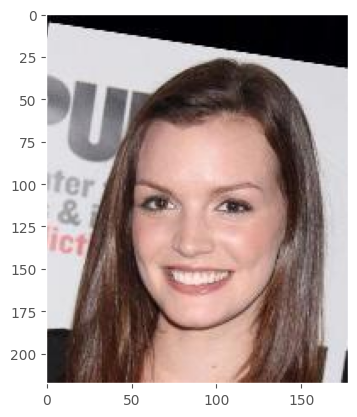

In [11]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] #some attributes

### Distribution of the Attribute

Como se especificó anteriormente, este es un proyecto imaginario de reconocimiento del Género. Hay más sexo femenino que masculino en el conjunto de datos. Esto nos da una idea de la necesidad de equilibrar los datos en los próximos pasos.

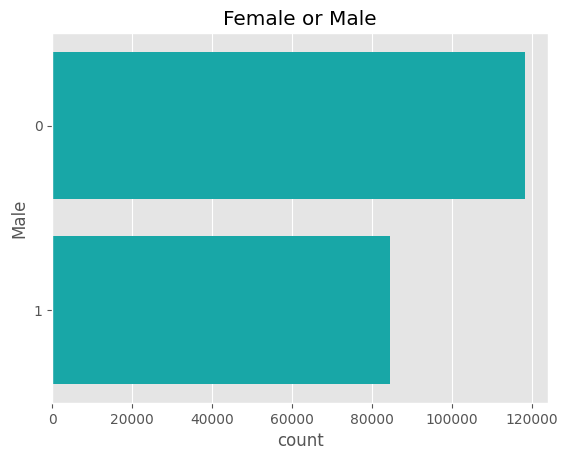

In [12]:
# Female or Male?
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.show()

## Step 2: Split Dataset into Training, Validation and Test

La partición recomendada de imágenes en entrenamiento, validación, prueba del conjunto de datos es:
* 1-162770 de entrenando
* 162771-182637 de validación
* 182638-202599 de tester

La partición está en el archivo <b>list_eval_partition.csv</b>

Debido al tiempo de ejecución, a estas alturas estaremos utilizando un número reducido de imágenes:

* Entrenamiento 20000 imágenes
* Validación 5000 imágenes
* Prueba 5000 Imágenes

In [13]:
# Recomended partition
df_partition = pd.read_csv('DataSources\CelebFacesAttributesDataset\list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [14]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

#### Join the partition and the attributes in the same data frame

In [15]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


### 2.1: Generate Partitions (Train, Validation, Test)

Es necesario equilibrar el número de imágenes para obtener un buen rendimiento del modelo; cada modelo tendrá su propia carpeta de datos de entrenamiento, validación y prueba equilibrada.

Este proyecto de grado explica cómo los datos de entrenamiento desequilibrados impactan en los modelos de CNN:

https://www.kth.se/social/files/588617ebf2765401cfcc478c/PHensmanDMasko_dkand15.pdf

En este paso crearemos funciones que nos ayudarán a crear cada partición.

In [16]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

## Step 3: Pre-processing Images: Data Augmentation

Generates Data Augmentation for iamges.

Data Augmentation permite generar imágenes con modificaciones a las originales. El modelo aprenderá de estas variaciones (cambio de ángulo, tamaño y posición), pudiendo predecir mejor imágenes nunca vistas que podrían tener las mismas variaciones en posición, tamaño y posición.

### 3.1. Let's start with an example: Data Augmentation

Así es como se verá una imagen después del aumento de datos (basado en los parámetros proporcionados a continuación).

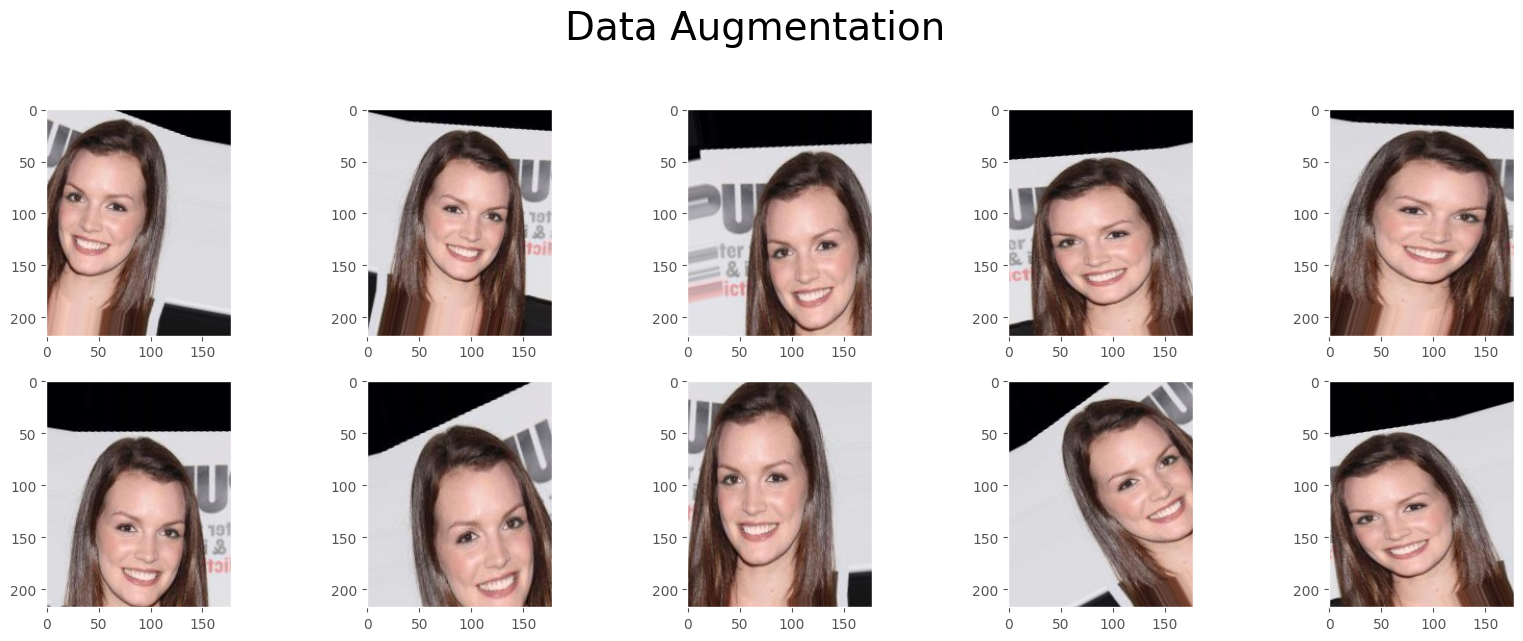

In [17]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

El resultado es un nuevo conjunto de imágenes con modificaciones del original, que permite al modelo aprender de estas variaciones para tomar este tipo de imágenes durante el proceso de aprendizaje y predecir mejor las imágenes nunca vistas.

### 3.2. Build Data Generators

In [18]:
# Train data
TRAINING_SAMPLES = 10000
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [19]:
# Validation Data
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

#'''
# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)
#'''

Con el generador de datos creado y los datos para la validación, estamos listos para comenzar a modelar.

## Step 4: Build the Model - Gender Recognition

### 4.1. Set the Model

In [20]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='DataSources/InceptionV3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

number of layers: 311


<h2>Inception-V3 model structure</h2>
Esta es la estructura del modelo Inception-V3, desarrollado sobre el conjunto de datos imagenet.

<img src="https://i.imgur.com/kdXUzu1.png" width="1000px"/>
source: https://hackathonprojects.files.wordpress.com/2016/09/74911-image03.png

Las capas superiores (incluida la clasificación) no están incluidas. Estas capas serán reemplazadas por las siguientes capas:

In [21]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

<h2>New Top layers</h2>
Capas a entrenar con el nuevo modelo.
<img src="https://i.imgur.com/rWF7bRY.png" width="800px"/>

In [22]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

### 4.2. Train Model

In [23]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

In [24]:
TRAINING_SAMPLES = 10000
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

C:\Users\Dany\AppData\Local\Temp\ipykernel_936\604997990.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_.fit_generator(train_generator


Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 0.6426 - accuracy: 0.6185
Epoch 1: val_loss improved from inf to 0.85557, saving model to weights.best.inc.male.hdf5
625/625 [==============================] - 4287s 7s/step - loss: 0.6426 - accuracy: 0.6185 - val_loss: 0.8556 - val_accuracy: 0.4920
Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.7614
Epoch 2: val_loss improved from 0.85557 to 0.78781, saving model to weights.best.inc.male.hdf5
625/625 [==============================] - 4288s 7s/step - loss: 0.4952 - accuracy: 0.7614 - val_loss: 0.7878 - val_accuracy: 0.5125
Epoch 3/20
625/625 [==============================] - ETA: 0s - loss: 0.4306 - accuracy: 0.7990
Epoch 3: val_loss did not improve from 0.78781
625/625 [==============================] - 4074s 7s/step - loss: 0.4306 - accuracy: 0.7990 - val_loss: 0.8536 - val_accuracy: 0.5155
Epoch 4/20
625/625 [==============================] - ETA: 0s - loss: 0.3941 - a

#### El mejor modelo después de NUM_epech obtuvo una precisión sobre los datos de validación del 95,75 %.

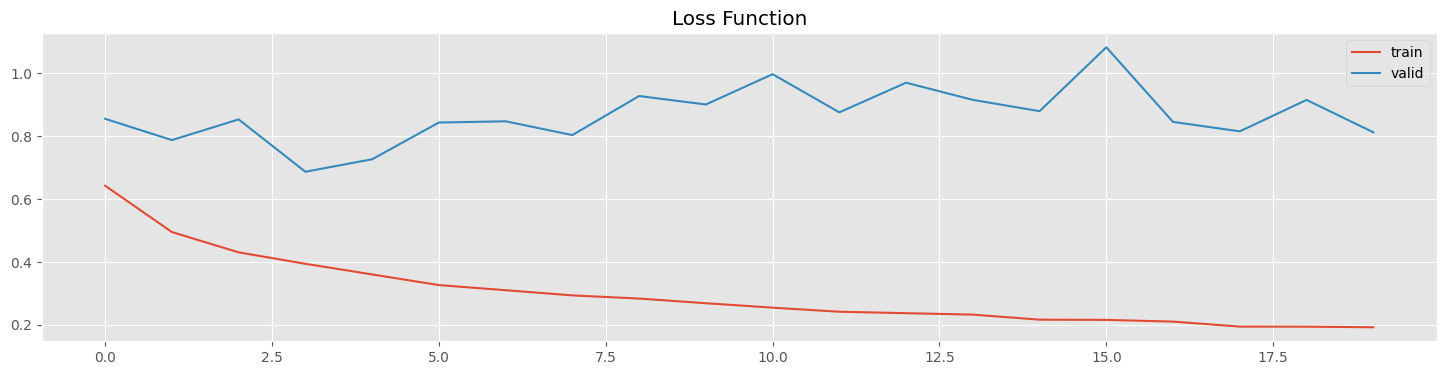

In [25]:
# Plot loss function value through epochs

plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

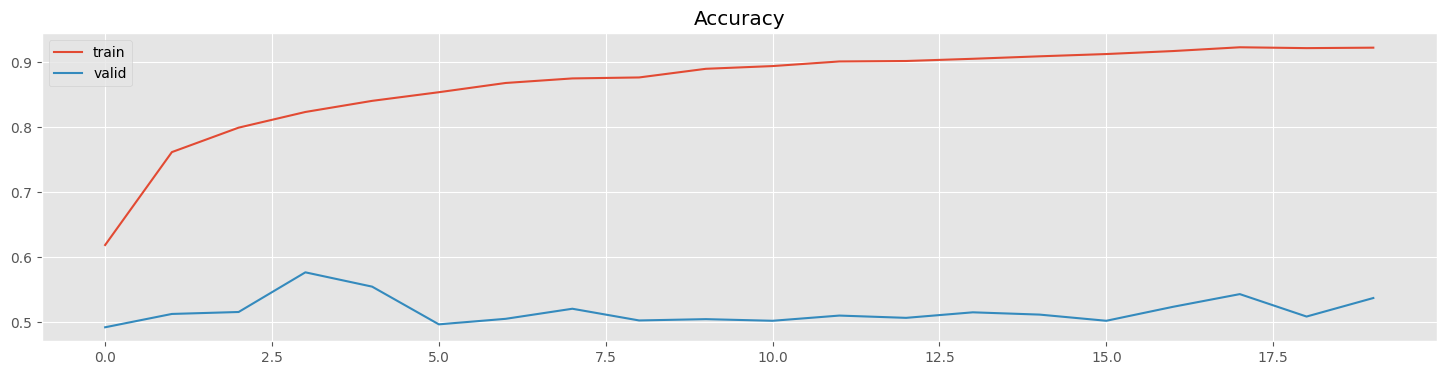

In [26]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

## Save Model and Load

In [27]:
model_.save("model.hdf5")

model_ = load_model("model.hdf5")

### 4.3. Model Evaluation

In [28]:
#load the best model
model_.load_weights('weights.best.inc.male.hdf5')

In [29]:
# Test Data
x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

1/1 [==============================] - 0s 200ms/step
Model Evaluation
Test accuracy: 56.0500%
f1_score: 0.5646359583952452


### 5. Conclusion

El modelo construido que utiliza el aprendizaje de transferencia de InceptionV3 y agrega capas personalizadas reconoce con éxito el género que brinda cierta imagen con <b>94.8% de precisión sobre los datos de prueba</b>. No obstante, se detectan algunas limitaciones y oportunidades de mejora:

* Entrena los algoritmos con todo el conjunto de datos de imágenes. Debido a la limitación de recursos computacionales, el modelo se entrenó con un subconjunto de imágenes. Contando con una máquina adecuada, se puede entrenar el modelo incluyendo todas las imágenes. Esto hará que el algoritmo aprenda de diferentes contextos de la imagen, dándole más experiencia para predecir mejores imágenes nunca vistas.

* Usar estructuras de diferencias para las CNN. Este enfoque podría brindar un mejor rendimiento al modelo; de todos modos, es una tarea costosa, ya que el modelo se puede medir en el conjunto de datos de prueba después de entrenarlo, y esto requiere tiempo y recursos computacionales.

* Al ver las imágenes del conjunto de datos de CelebA, la mayoría de las imágenes son casi un primer plano de la cara del sujeto, lo que lleva al modelo a aprender de este tipo de imágenes, y en situaciones en las que el sujeto es solo un pequeño parte de una imagen, el modelo no podría funcionar bien. Para lidiar con esto, se pueden agregar datos de preprocesamiento más sofisticados o complementar el conjunto de datos con imágenes que no se basan completamente en primeros planos de la cara del sujeto.

* Los entornos donde hay más de un sujeto en la imagen no formaban parte de este proyecto, pero es una buena mejora para desarrollar una mejor aplicación. OpenCV es un buen candidato para ayudar con este desarrollo, ya que es muy preciso para detectar heces y su posición en las imágenes, luego esa parte de la imagen (las caras) se puede clasificar por separado utilizando los modelos desarrollados en este proyecto.

### 6. Let's play with the Model

In [30]:
#dictionary to name the prediction
gender_target = {0: 'Female'
                , 1: 'Male'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    '''
    Display the results in HTML
    
    '''

    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"
        
    if prediction[1] <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [31]:
def gender_prediction(filename):
    '''
    predict the gender
    
    input:
        filename: str of the file name
        
    return:
        array of the prob of the targets.
    
    '''
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)
    
    return result
    

In [32]:

#select random images of the test partition
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(8)

for index, target in df_to_test.iterrows():
    result = gender_prediction(images_folder + index)
    
    #display result
    display_result(images_folder + index, result[0], target['Male'])

1/1 [==============================] - 0s 207ms/step


C:\Users\Dany\AppData\Local\Temp\ipykernel_936\3451913897.py:11: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  i.thumbnail((200, 200), Image.LANCZOS)


TypeError: 'module' object is not callable